In [15]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [16]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
valset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

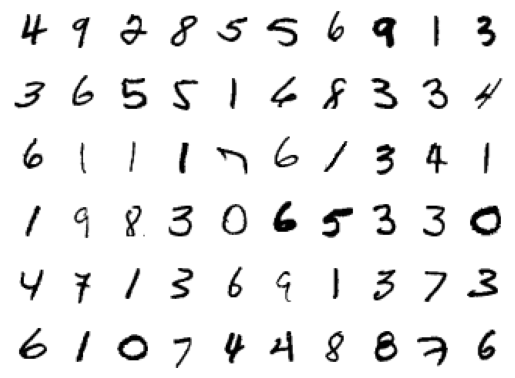

In [17]:
figure = plt.figure()
num_of_images = 60

dataiter = iter(trainloader)
images, labels = next(dataiter)

for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [18]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


In [19]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 15
loss_optim = []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
        loss_optim.append(running_loss/len(trainloader))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

In [20]:
# Hyperparameters
learning_rate = 0.003
momentum = 0.9

# Initialize velocity for momentum
velocity = {param: torch.zeros_like(param) for param in model.parameters()}

# Function for custom SGD with momentum
def custom_sgd_with_momentum(model, learning_rate, momentum):
    with torch.no_grad():  # Disable gradient tracking for updates
        for param in model.parameters():
            if param.grad is not None:
                # Update velocity with momentum
                velocity[param] = momentum * velocity[param] + param.grad
                
                # Update parameters with learning rate and velocity
                param -= learning_rate * velocity[param]
                
                # Zero out the gradients after updating
                param.grad.zero_()

# Training loop with custom optimizer
time0 = time()
epochs = 15
loss_optim = []

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        output = model(images)
        loss = criterion(output, labels)
        
        # Backpropagate to calculate gradients
        loss.backward()
        
        # Update parameters using custom SGD with momentum
        custom_sgd_with_momentum(model, learning_rate, momentum)
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
        loss_optim.append(running_loss/len(trainloader))

print("\nTraining Time (in minutes) =", (time()-time0)/60)


Epoch 0 - Training loss: 0.6501349779382062
Epoch 1 - Training loss: 0.2862804005109171
Epoch 2 - Training loss: 0.22303492698603983
Epoch 3 - Training loss: 0.17765395932677966
Epoch 4 - Training loss: 0.1464990375023375
Epoch 5 - Training loss: 0.12581169867375766
Epoch 6 - Training loss: 0.11110002383974983
Epoch 7 - Training loss: 0.09842083692105848
Epoch 8 - Training loss: 0.08812277844008892
Epoch 9 - Training loss: 0.0792294523836588
Epoch 10 - Training loss: 0.07192732235029546
Epoch 11 - Training loss: 0.06402955326124597
Epoch 12 - Training loss: 0.06081613464686059
Epoch 13 - Training loss: 0.05509025364571106
Epoch 14 - Training loss: 0.051110946422647324

Training Time (in minutes) = 2.016051006317139


In [21]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9758


In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(range(0, 15), loss_with_pytorch, 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig("./Images/with_sgd_loss.pdf")
plt.show()